<a href="https://colab.research.google.com/github/edypidy/studyblog/blob/master/%5Bkaggle_study%5D_Heart_Attack_Analysis_%26_Prediction_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "[SSUDA]Heart Desease 데이터 셋 분석과 train_test split에 따른 Accuracy"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Daniel Lee - edypidy
- categories: [kaggle, heart desease, jupyter, classification, XGboost, AdaBoost, Lgbm, Logistic Regression, RandomForest, MLPClassifier]

# Data copyright
이번에 분석해볼 데이터는 캐글의 Heart Desease 데이터입니다. 출처는 아래와 같습니다.

        https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

# Intro

> 개인적으로 진행중인 kaggle review에서의 이번주차 데이터 셋입니다. 캐글 코드를 매우 많이 참고한 점을 밝힙니다. 참고한 코드 주소는 아래에 참고한 플랏에서 밝혀놓았습니다.

> 아래의 바닐라 모델 중 Accuracy가 좋은 것을 튜닝으로 개선시켜 볼 것입니다.

        XGboost, AdaBoost, Lgbm, Logistic Regression, RandomForest, MLPClassifier

# Data description


* Age : Age of the patient

* Sex : Sex of the patient

* exang: exercise induced angina (1 = yes; 0 = no)

* ca: number of major vessels (0-3)

* cp : Chest Pain type chest pain type

        Value 1: typical angina
        Value 2: atypical angina
        Value 3: non-anginal pain
        Value 4: asymptomatic
* trtbps : resting blood pressure (in mm Hg)

* chol : cholestoral in mg/dl fetched via BMI sensor

* fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

* rest_ecg : resting electrocardiographic results

        Value 0: normal
        Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach : maximum heart rate achieved

* target : 0= less chance of heart attack 1= more chance of heart attack

# Preparation

## Libraries & Workspace setting

In [ ]:
#collapse-hide
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import scipy.stats as ss

sns.set_palette('deep')
sns.set_color_codes()
sns.set_style('white')

## Load Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/edypidy/Datasets/main/Heart%20Attack%20Analysis%20%26%20Prediction%20Dataset/heart.csv')
df.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


## Train Test Split

여러 모델에 적용하기 위해선 스케일 조정 작업이 필요해 보이고, 연속형, 명목형, 순서형 변수들의 구분이 필요하다.
순서형 변수의 경우 스케일을 맞추기 위해 one-hot encoding을 하는 것이 좋아 보인다.

        Continuous  : age, trtbps, chol, thalachh, oldpeak
        Cat_Ordered : cp, restecg, slp, caa, thall
        Cat_Nominal : sex, fbs, exng

In [ ]:
#collapse-hide
continuous = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
cat_ordered = ['cp', 'restecg', 'slp', 'caa', 'thall']
cat_nominal = ['sex', 'fbs', 'exng']
categorical = cat_ordered + cat_nominal

In [ ]:
#collapse-hide
# train_test가 나눠져 있지 않다. 따로 빼두자..
full = pd.get_dummies(df, columns=categorical)

train, test로 나눠져있는 것이 아닌 feature - target 이 모두 있는 데이터 셋이다. 모델의 최종 검증용 데이터가 따로 있는 것이 아니기 때문에 데이터를 split 해놓을 필요가 있다.(_최대한 실전 문제처럼 해보자_)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
train_full, test_full = train_test_split(full, test_size=0.2, shuffle=True, random_state=42)

stratify를 설정 해야할지 고민을 좀 했다. 하지만 실제 데이터 셋이라면 target(output)의 비율이 완전히 동일할리가 없다(분포는 비슷하겠지만). (default)shuffle=True 로 둔다. 

In [ ]:
#collapse-hide
print('train shape & target ratio : ', train.shape, train_full.shape, '%.2f'%train.output.mean())
print('test shape & target ratio : ', test.shape, test_full.shape, '%.2f'%test.output.mean())

train shape & target ratio :  (242, 14) (242, 31) 0.55
test shape & target ratio :  (61, 14) (61, 31) 0.52


target의 비율이라도 잘 나눠졌는지 확인하고 시작하자.

# EDA

## Peek

### Isna?

In [ ]:
#collapse-hide
train.isna().apply(pd.value_counts)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
False,242,242,242,242,242,242,242,242,242,242,242,242,242,242


Missing value는 없다.

### General Stats

In [ ]:
#collapse-hide
train.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,54.462810,0.657025,0.991736,130.359504,246.842975,0.128099,0.553719,150.115702,0.314050,1.013223,1.421488,0.681818,2.301653,0.549587
std,9.204492,0.475687,1.022533,16.828858,52.795465,0.334893,0.530410,22.352398,0.465098,1.102577,0.607724,0.990620,0.593811,0.498566
min,29.000000,0.000000,0.000000,94.000000,131.000000,0.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,212.000000,0.000000,0.000000,136.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.500000,1.000000,1.000000,130.000000,239.500000,0.000000,1.000000,154.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,165.750000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,192.000000,564.000000,1.000000,2.000000,202.000000,1.000000,5.600000,2.000000,4.000000,3.000000,1.000000


## Univariate Analysis

캐글 탐색 중에 바이올린 차트를 너무 세련되게 그려놓은 분이 있어서 참고 해봤다. 주소는 아래와 같다.

        https://www.kaggle.com/abhinavgargacb/heart-attack-eda-predictor-95-accuracy-score#Exploratory-Data-Analysis-

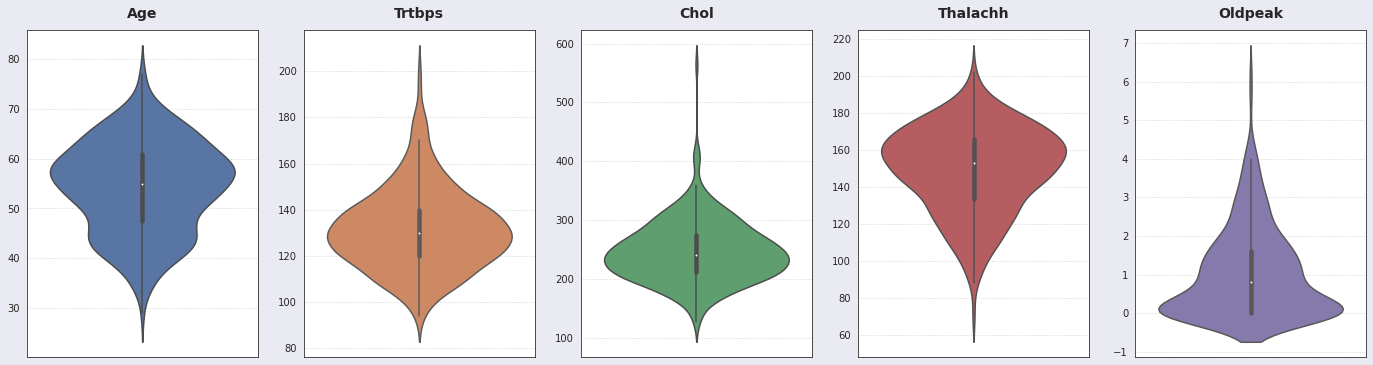

In [ ]:
#collapse-hide
fig = plt.figure(figsize=(24, 6))
axes = [fig.add_subplot(1,5,i) for i in range(1, 6)]
fig.patch.set_facecolor('#eaeaf2')

for i in range(5):
    var = continuous[i]
    ax = axes[i]
    ax.grid(axis='y', linestyle=':')
    ax.text(0.5, 1.05, var.title(),
            horizontalalignment='center', verticalalignment='center',
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    color = sns.color_palette('deep')[i]
    sns.violinplot(data=df, y=var, ax=ax, color=color)
    ax.set_xlabel('')
    ax.set_ylabel('')

* age : 표본이 중장년층을 중심으로 퍼져있다. 아무래도 심장병이라는 질환의 특성상 병원까지 와서 표본으로 수집되는 어린 환자는 적고, 고령층의 경우 인구수가 적어서 그런 것으로 생각된다.
* trtbps : 일정 범위 내에서 정규분포와 같은 모습을 보이나 오른쪽 꼬리가 꽤 길게 늘어져 있다.
* chol : 콜레스테롤은 대표적인 심장병의 원인 중 하나로 꼽힌다. 콜레스테롤이 아주 높은 outlier가 보인다.
* thalachh : 왼쪽 꼬리가 꽤나 두꺼운 분포이다. (최대 심박수가 60인 사람은 평소 심박수가 몇일지 궁금해진다)
* oldpeak : 오른쪽 꼬리가 아주 두껍고 멀리 떨어진 outlier가 보인다.

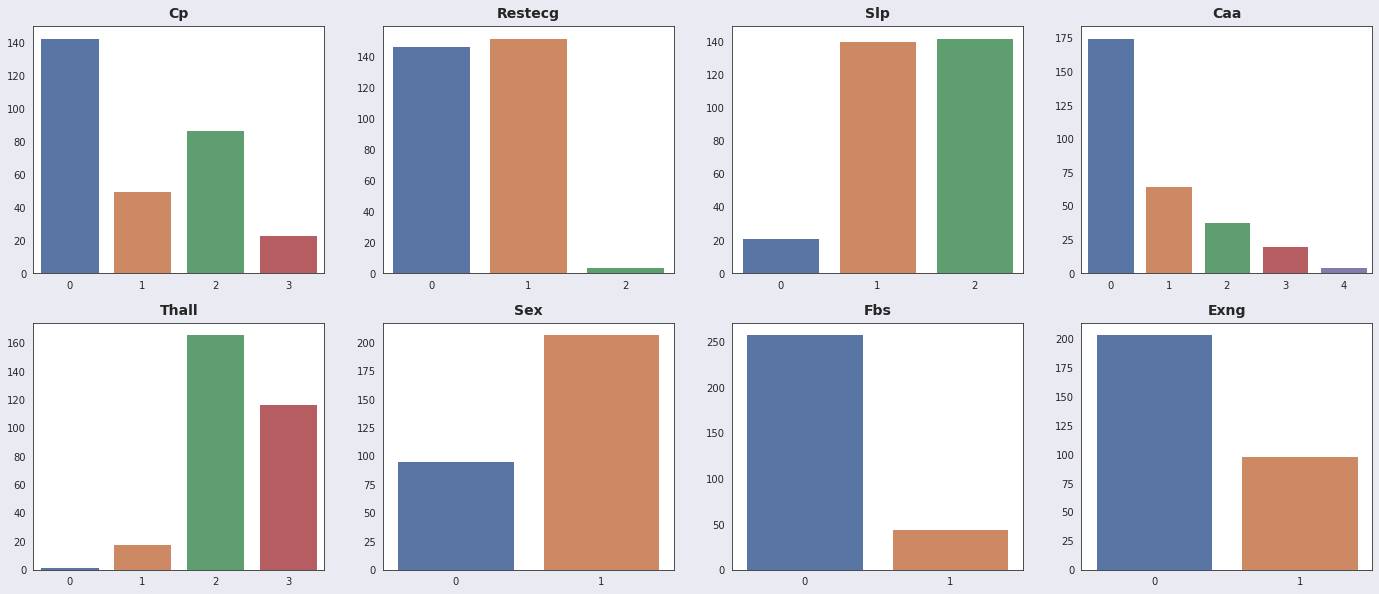

In [ ]:
#collapse-hide
fig = plt.figure(figsize=(24, 10))
axes = [fig.add_subplot(2,4,i) for i in range(1, 9)]
fig.patch.set_facecolor('#eaeaf2')

for i in range(8):
    var = categorical[i]
    ax = axes[i]
    ax.text(0.5, 1.05, var.title(),
            horizontalalignment='center', verticalalignment='center',
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    sns.countplot(data=df, x=var, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')

* 모든 특성에서 범주간의 불균형이 보인다.
* 특히 restecg, slp, caa, thall 에서 아주 심하고 fbs와 cp 에서도 큰 불균형이 발견된다. exng는 다른 특성들에 비해 불균형이 심해보이진 않는다.

## Bivariate Analysis

여기서부턴 test의 target값이 df에 포함 되었기 때문에 원본 데이터를 보지 못한다.(실전이라면 univariate analysis까지만 데이터를 합하여 볼 수 있을 것이다.) train 데이터로 보도록 하자.(실전처럼!)

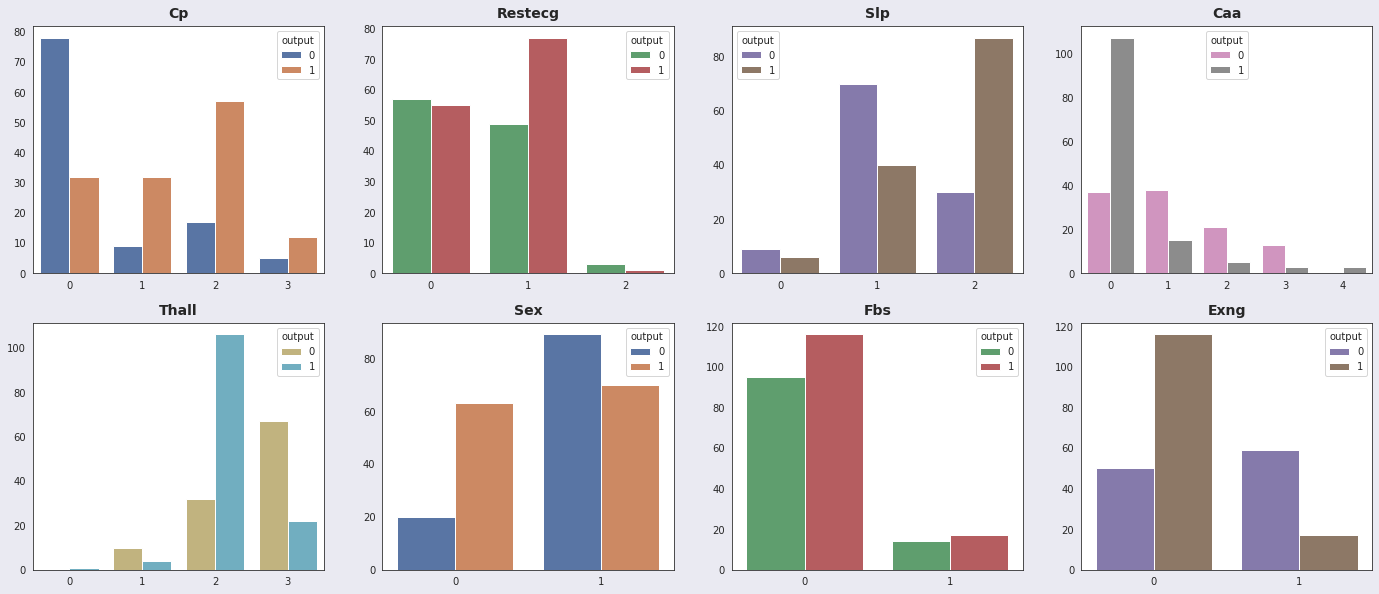

In [ ]:
#collapse-hide
fig = plt.figure(figsize=(24, 10))
axes = [fig.add_subplot(2,4,i) for i in range(1, 9)]
fig.patch.set_facecolor('#eaeaf2')


for i in range(8):
    var = categorical[i]
    ax = axes[i]
    ax.text(0.5, 1.05, var.title(),
            horizontalalignment='center', verticalalignment='center',
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    colorIndex = (2*(i)) % 10
    color1 = sns.color_palette('deep')[colorIndex]
    color2 = sns.color_palette('deep')[colorIndex + 1]
    sns.countplot(data=train, x=var, ax=ax, hue='output',
                  palette=[color1, color2])
    ax.set_xlabel('')
    ax.set_ylabel('')

1이 조금 더 많은 것은 train.output의 1이 0보다 조금 더 많았던 것 때문이라 생각할 수 있겠지만 조금 더 많은 정도가 아니거나 거꾸로 0이 많은 경우가 있다면 꽤나 유의미한 특성이라 볼 수 있을 것이다.

* cp, slp, caa, thall, sex, exng 특성을 보면 특정 범주에 따라 1과 0의 비율이 역전 되는 모습이 많이 보인다.
* restecg, fbs의 경우엔 그다지 유의미한 변화가 없다.

### Cramer's V

그래프를 가져온 문서에서 거의 그대로 가져왔다. Cramer's V는 **두 이산형 변수의 연관성 척도**로 쓰인다. 특히 비교대상 범주가 3개 이상일 때 쓰인다. 

Pearson 카이제곱 통계량을 기반으로 만들어진 테스트이다.(계산적인 부분이 궁금하다면 [여기](https://edypidy.tistory.com/2)를 클릭하자)

In [ ]:
#collapse-hide
def cramers_corrected_stat(x, y):
    result = -1

    conf_matrix = pd.crosstab(x, y)

    if conf_matrix.shape[0] == 2:
        correct = False
    else:
        correct = True

    chi2, p = ss.chi2_contingency(conf_matrix, correction=correct)[0:2]

    n = sum(conf_matrix.sum())
    phi2 = chi2/n
    r, k = conf_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    result = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return round(result, 6), round(p, 6)


for var in categorical:
    x = train[var]
    y = train['output']
    cramersV, p = cramers_corrected_stat(x, y)
    print(f'For variable {var}, Cramer\'s V: {cramersV} and p value: {p}')

For variable cp, Cramer's V: 0.463569 and p value: 0.0
For variable restecg, Cramer's V: 0.110035 and p value: 0.08517
For variable slp, Cramer's V: 0.36724 and p value: 0.0
For variable caa, Cramer's V: 0.487659 and p value: 0.0
For variable thall, Cramer's V: 0.504115 and p value: 0.0
For variable sex, Cramer's V: 0.297875 and p value: 2e-06
For variable fbs, Cramer's V: 0.0 and p value: 0.988529
For variable exng, Cramer's V: 0.439424 and p value: 0.0


* fbs는 연관성이 없어보이고 restecg는 유의수준 $\alpha = 0.05$에서 아쉽게 기각이 되지 않는다.
* 위의 두 변수를 제외한 모든 변수에서 귀무가설이 기각되었다.

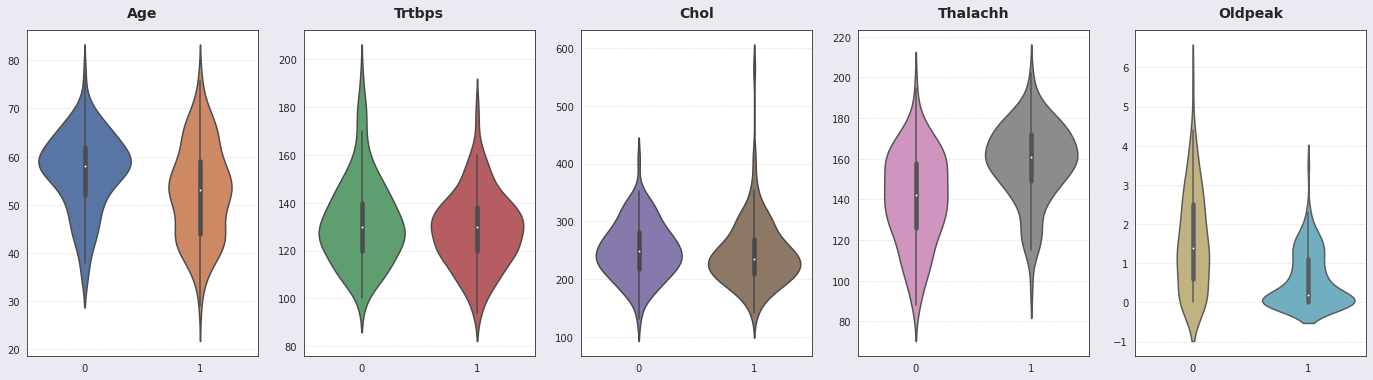

In [ ]:
#collapse-hide
fig = plt.figure(figsize=(24, 6))
axes = [fig.add_subplot(1,5,i) for i in range(1, 6)]
fig.patch.set_facecolor('#eaeaf2')

for i in range(5):
    var = continuous[i]
    ax = axes[i]
    ax.grid(axis='y', linestyle=':')
    ax.text(0.5, 1.05, var.title(),
            horizontalalignment='center', verticalalignment='center',
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    colorIndex = (2*(i)) % 10
    color1 = sns.color_palette('deep')[colorIndex]
    color2 = sns.color_palette('deep')[colorIndex + 1]
    sns.violinplot(data=train, y=var, x='output', ax=ax, palette=[color1, color2])
    ax.set_xlabel('')
    ax.set_ylabel('')

* 수집된 표본에선 의외로 환자의 연령대가 다양하다.
* trtbps, chol, oldpeak 에선 output에 따라 outlier가 다르게 관측된다. 

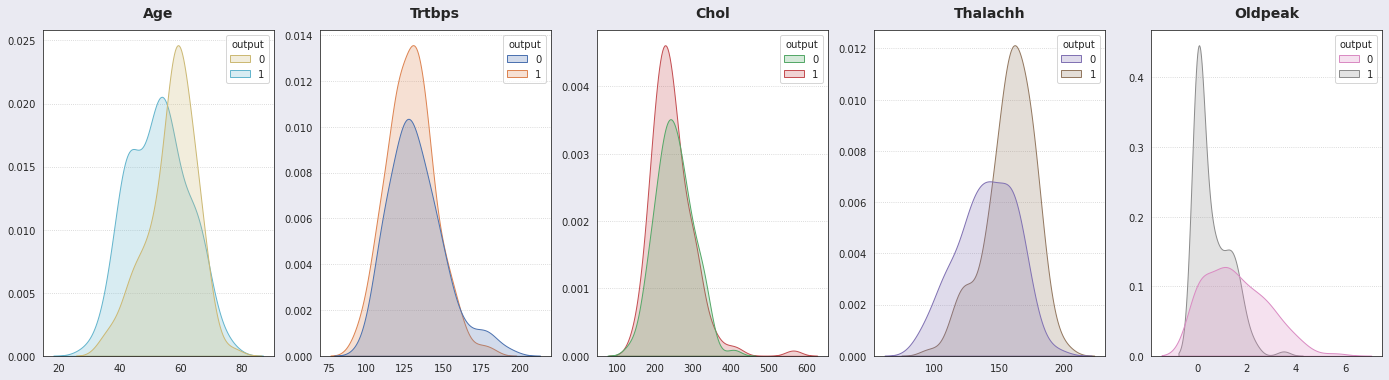

In [ ]:
#collapse-hide
fig = plt.figure(figsize=(24, 6))
axes = [fig.add_subplot(1,5,i) for i in range(1, 6)]
fig.patch.set_facecolor('#eaeaf2')

for i in range(5):
    var = continuous[i]
    ax = axes[i]
    ax.grid(axis='y', linestyle=':')
    ax.text(0.5, 1.05, var.title(),
            horizontalalignment='center', verticalalignment='center',
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    colorIndex = (2*(i - 1)) % 10
    color1 = sns.color_palette('deep')[colorIndex]
    color2 = sns.color_palette('deep')[colorIndex + 1]
    sns.kdeplot(data=train, x=var, hue='output', ax=ax, fill=True,
                palette=[color1, color2])
    ax.set_xlabel('')
    ax.set_ylabel('')

* age, thalachh, oldpeak 에서 큰 영향이 있는 것으로 보인다.
* trtbps, chol 은 그다지 큰 영향이 있는 것으로 보이진 않는다. 

### Kruskal-Wallis H-test

분포 모형이 통계적으로 유의하게 차이가 있는지 확인해보자. 모든 분포가 정규성을 갖지는 않기에 평균보다는 중위수에 대한 검정을 하자.

In [ ]:
#collapse-hide
for var in continuous:
    gp = train[[var, 'output']].groupby(['output'])
    gp_array = [group[var].to_numpy() for name, group in gp]
    kstat, p = ss.kruskal(*gp_array)
    kstat, p = round(kstat, 6), round(p, 6)
    print(f'For variable {var}, Kruskal-Wallis H-test: {kstat} and p value: {p}')

For variable age, Kruskal-Wallis H-test: 14.700765 and p value: 0.000126
For variable trtbps, Kruskal-Wallis H-test: 1.288149 and p value: 0.256389
For variable chol, Kruskal-Wallis H-test: 2.346947 and p value: 0.125529
For variable thalachh, Kruskal-Wallis H-test: 36.863825 and p value: 0.0
For variable oldpeak, Kruskal-Wallis H-test: 42.479336 and p value: 0.0


### Point Biserial test

다른 검정을 하고싶다면 피어슨 상관계수와 값이 동일하긴 하지만 Point Biserial test를 해보자

In [ ]:
#collapse-hide
for var in continuous:
    pbistat, p = ss.pointbiserialr(train[var], train['output'])
    pbistat, p = round(pbistat, 6), round(p, 6)
    print(f'For variable {var}, Point Biserial : {pbistat} and p value: {p}')

For variable age, Point Biserial : -0.233782 and p value: 0.000244
For variable trtbps, Point Biserial : -0.104257 and p value: 0.10569
For variable chol, Point Biserial : -0.057714 and p value: 0.371366
For variable thalachh, Point Biserial : 0.393415 and p value: 0.0
For variable oldpeak, Point Biserial : -0.447305 and p value: 0.0


* 두 검정 모두 동일하게 귀무가설을 채택&기각 하였다. 두 결과에서 trtbps, chol 모두 생각보다 작은 값을 보인다.

### Correlation of continuous variables(pearson)

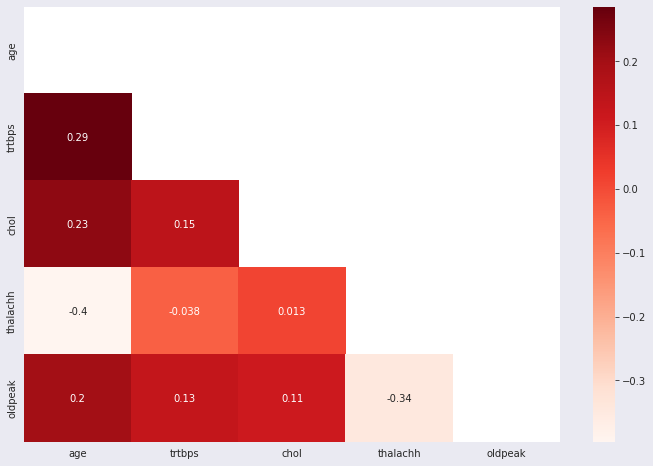

In [ ]:
#collapse-hide
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('#eaeaf2')
corr_matrix = train[continuous].corr()
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, cmap='Reds', annot=True, mask=mask)
plt.show()

* 크기가 커봐야 0.4 정도이다. 그다지 높은 선형 상관을 띠는 특성 쌍은 없다.

### Correlation of categorical variables(Cramer's V)

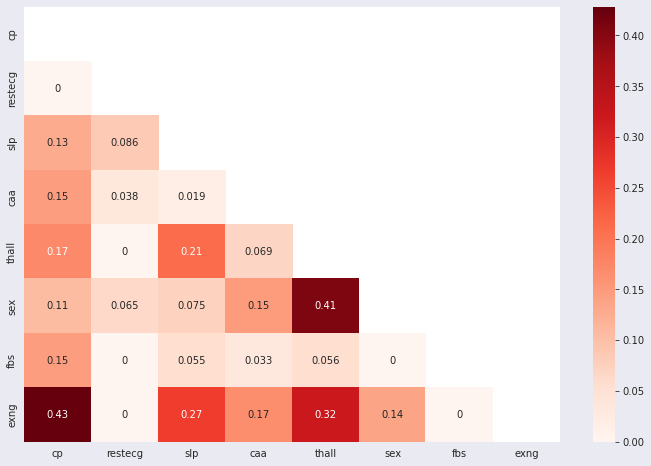

In [ ]:
#collapse-hide
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('#eaeaf2')
corr_matrix = train[categorical].corr(method=lambda x, y: cramers_corrected_stat(x, y)[0])
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, cmap='Reds', annot=True, mask=mask)
plt.show()

* 커봐야 0.43정도이다. 강한 상관을 보이는 특성쌍은 없는 것으로 보인다.

# EDA Conclusion

## Continuous
* outlier가 많이 관측되었다. 모델 적합시 영향을 많이 줄 것으로 보인다.

* 스케일을 맞출 필요가 있다.

* oldpeak의 경우 분포가 오른쪽 꼬리를 길게 달고 있다. 하지만 변수에 대한 정확한 설명이 없어 변환이 어려울듯 하다.

* p-value가 생각보다 작아 trtbps, chol이 output 값과 아예 연관이 없다고 보기는 어려울 수 있다. 

* 특성들 간의 선형 상관관계는 없는 것으로 보인다.

## Categorical
* 모든 특성에서 범주 간의 심한 불균형이 관측된다.

* fbs의 경우 심한 불균형이 있고 output과 연관이 거의 없는 것으로 검정 되었으므로 제거할 필요가 있어보인다.

* 특성들 간의 상관관계는 없는 것으로 보인다.

# Model comparison

In [ ]:
#collapse-hide
# Preprocessing
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# Basic Model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Boosting Model
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# Neural Network Model
from sklearn.neural_network import MLPClassifier

In [ ]:
X_train = train_full.drop(['fbs_0', 'fbs_1', 'output'], axis=1)
y_train = train_full['output']
X_test = test_full.drop(['fbs_0', 'fbs_1', 'output'], axis=1)
y_test = test_full['output']

scaler = StandardScaler()
scaler.fit(X_train[continuous])
X_train[continuous] = scaler.transform(X_train[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])
# one-hot encoding is already done

In [ ]:
# 비교 모델
models = {
          'SVM': SVC(),
          'Random Forest': RandomForestClassifier(),
          'Logistic Regression': LogisticRegression(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'AdaBoost Classifier': AdaBoostClassifier(),
          'XGBoost Classifier' : XGBClassifier(),
          'MultiLayer Perceptron Classifier' : MLPClassifier()
         }
scoring = {'Accuracy': make_scorer(accuracy_score),
           'F1_score': make_scorer(f1_score),
           'Recall' : make_scorer(recall_score),
           'Precision' : make_scorer(precision_score)}

In [ ]:
scores = pd.DataFrame({})
for name, model in models.items():
    score = cross_validate(model, X_train, y_train, scoring=scoring)
    temp = pd.DataFrame(score).mean()
    scores[name] = temp
scores = scores.T.drop('score_time', axis=1)
scores

,fit_time,test_Accuracy,test_F1_score,test_Recall,test_Precision
SVM,0.005021,0.826020,0.842251,0.856125,0.832761
Random Forest,0.150434,0.805782,0.819559,0.811681,0.832945
Logistic Regression,0.008422,0.834439,0.851540,0.871795,0.835409
Gradient Boosting,0.091337,0.818027,0.836435,0.849288,0.826028
AdaBoost Classifier,0.076684,0.768367,0.795258,0.819088,0.775694
XGBoost Classifier,0.058072,0.801531,0.821968,0.834473,0.810124
MultiLayer Perceptron Classifier,0.260454,0.834779,0.848088,0.841880,0.857307


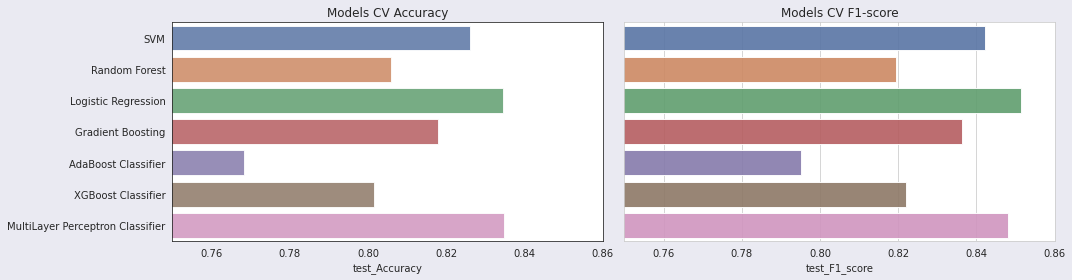

In [ ]:
#collapse-hide
fig = plt.figure(figsize=(15, 4))
fig.add_subplot(121)
fig.patch.set_facecolor('#eaeaf2')
sns.set_style('whitegrid')
plt.title('Models CV Accuracy')
sns.barplot(scores.test_Accuracy, scores.index, alpha=0.85)
plt.xlim((0.75, 0.86))

fig.add_subplot(122)
plt.title('Models CV F1-score')
sns.barplot(scores.test_F1_score, scores.index, alpha=0.9)
plt.yticks([])
plt.xlim((0.75, 0.86))
plt.tight_layout()
plt.show()

* Logistic Regression 모델이 Accuracy Score, F1 Score 모두 가장 높다.


## GridSearchCV

In [ ]:
#collapse-hide
from sklearn.model_selection import GridSearchCV
model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500, random_state=42)
params = {'C' : np.arange(0.1, 1, 0.1),
          'l1_ratio' : np.arange(0, 1, 0.05)}
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring=make_scorer(accuracy_score),
                  cv=5,
                  n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=42, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

In [ ]:
print(gs.best_params_)

{'C': 0.30000000000000004, 'l1_ratio': 0.1}


> 혹시나 해서 elasticnet penalty를 적용해봤지만 l2 만으로도 충분해보인다.

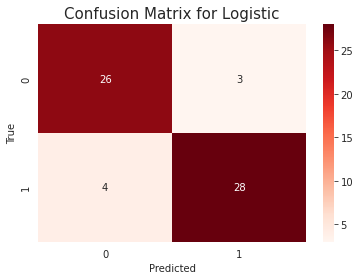

Accuracy :  0.8852459016393442
F1-score :  0.8888888888888888


In [ ]:
#collapse-hide
model= LogisticRegression(penalty='elasticnet',
                          solver='saga',
                          max_iter=500,
                          C=0.3,
                          l1_ratio=0.1,
                          random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
sns.heatmap(df_cm, annot=True, cmap='Reds')
plt.title('Confusion Matrix for Logistic', fontsize=15)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print('Accuracy : ',accuracy_score(y_test, y_pred))
print('F1-score : ',f1_score(y_test, y_pred))

* 점수가 기대한 것 보다 잘 나오지 않았다.
> 혹시 데이터셋이 얼마나 잘 나눠졌느냐에 따라 모델의 점수가 달라지지 않을까? 라는 의심이 든다. 데이터 셋의 크기가 작기 때문에 random_state에 따라 점수가 크게 달라질 수도 있겠다. 우선 random_state = 65로 나눠진 데이터 셋에 대해 실험해보자.

# 실험

## random_state=65 로 실험

In [ ]:
#collapse-hide
# random_state=65 dataset prep
X = df[['sex', 'restecg', 'cp', 'exng', 'thall', 'caa', 'slp', 'age',
        'trtbps', 'chol', 'thalachh', 'oldpeak']]
y = df['output']

# models & scoring
models = {
          'SVM': SVC(),
          'Random Forest': RandomForestClassifier(),
          'Logistic Regression': LogisticRegression(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'AdaBoost Classifier': AdaBoostClassifier(),
          'XGBoost Classifier' : XGBClassifier(),
          'MultiLayer Perceptron Classifier' : MLPClassifier()
         }
scoring = {'Accuracy': make_scorer(accuracy_score),
           'F1_score': make_scorer(f1_score),
           'Recall' : make_scorer(recall_score),
           'Precision' : make_scorer(precision_score)}

In [ ]:
encode_columns = categorical.copy()
encode_columns.remove('fbs')

X = pd.get_dummies(X, columns=encode_columns)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=65) #this

scaler = StandardScaler()
scaler.fit(X_train[continuous])
X_train[continuous] = scaler.transform(X_train[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])

In [ ]:
#collapse-hide
scores = pd.DataFrame({})
for name, model in models.items():
    score = cross_validate(model, X_train, y_train, scoring=scoring)
    temp = pd.DataFrame(score).mean()
    scores[name] = temp
scores = scores.T.drop('score_time', axis=1)
scores

,fit_time,test_Accuracy,test_F1_score,test_Recall,test_Precision
SVM,0.004664,0.810034,0.829819,0.856410,0.806929
Random Forest,0.150327,0.789456,0.811416,0.833903,0.792085
Logistic Regression,0.010863,0.834864,0.853075,0.886610,0.825573
Gradient Boosting,0.088992,0.743793,0.776820,0.818519,0.741690
AdaBoost Classifier,0.076208,0.747874,0.772512,0.788319,0.763996
XGBoost Classifier,0.034040,0.776956,0.805907,0.856695,0.763046
MultiLayer Perceptron Classifier,0.293770,0.809949,0.830393,0.856125,0.807823


CV라서 그런지 생각보다 드라마틱한 변화는 없다. 오히려 내려간 느낌이다. 데이터 셋이 작기 때문에 당연한 것이라 생각된다.

In [ ]:
#collapse-hide
from sklearn.model_selection import GridSearchCV
model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500, random_state=42)
params = {'C' : np.arange(0.1, 1, 0.1),
          'l1_ratio' : np.arange(0, 1, 0.05)}
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring=make_scorer(accuracy_score),
                  cv=5,
                  n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=42, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

In [ ]:
#collapse-hide
print(gs.best_params_)

{'C': 0.1, 'l1_ratio': 0.0}


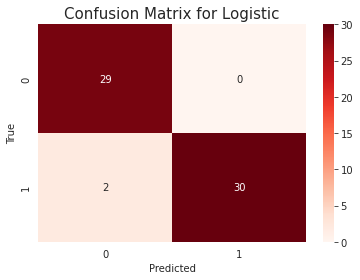

Accuracy :  0.9672131147540983
F1-score :  0.967741935483871


In [ ]:
#collapse-hide
model= LogisticRegression(penalty='l2',
                          max_iter=500,
                          C=0.1,
                          random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
sns.heatmap(df_cm, annot=True, cmap='Reds')
plt.title('Confusion Matrix for Logistic', fontsize=15)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print('Accuracy : ',accuracy_score(y_test, y_pred))
print('F1-score : ',f1_score(y_test, y_pred))

random_state=65 에선 점수가 무려 96.72%로 나온다. 혹시 더 잘 나눠주는 random_state는 없을까?

## random_state = 0 ~ 999

In [ ]:
#collapse-hide
Accuarcy_list = []
F1_list = []
for i in range(1000):
    X = df[['sex', 'restecg', 'cp', 'exng', 'thall', 'caa', 'slp', 'age',
        'trtbps', 'chol', 'thalachh', 'oldpeak']]
    y = df['output']
    encode_columns = categorical.copy()
    encode_columns.remove('fbs')

    X = pd.get_dummies(X, columns=encode_columns)

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=i)

    scaler = StandardScaler()
    scaler.fit(X_train[continuous])
    X_train[continuous] = scaler.transform(X_train[continuous])
    X_test[continuous] = scaler.transform(X_test[continuous])

    model = LogisticRegression(penalty='l2', max_iter=500)
    params = {'C' : np.arange(0.1, 1, 0.1),}
    gs = GridSearchCV(estimator=model,
                      param_grid=params,
                      scoring=make_scorer(accuracy_score),
                      cv=5,
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    C = gs.best_params_['C']
    model= LogisticRegression(penalty='l2',
                              max_iter=500,
                              C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    Accuarcy_list.append(acc)
    F1_list.append(f1)

(0.78, 1.0)

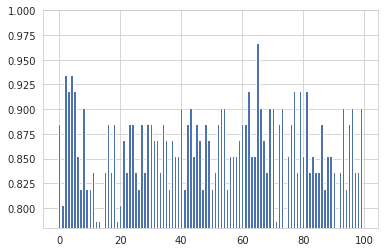

In [ ]:
plt.bar(range(100),Accuarcy_list[0:100])
plt.ylim((0.78, 1))

In [ ]:
max(Accuarcy_list)

0.9672131147540983

random_state = 0 ~ 99 까지의 그래프만 그려보아도 65번이 가장 높아보이는 것을 알 수 있다. random_state=65 에서의 Accuracy가 96.72% 였으니 0~999에서도 random_state=65 에서의 점수가 가장 잘 나오는 것이라 결론지을 수 있겠다.

# 느낀점

> 데이터셋이 작은만큼 어떻게 데이터가 나눠졌는가에 따라 점수가 크게 갈린다.

오히려 모델을 잘 선정하고 튜닝하는 것보다 데이터 셋이 잘 나눠졌을 때 점수 상승 폭이 더욱 컸다. 아무래도 이번 분석은 모델, 튜닝, 이런 것들 보다도 데이터셋의 크기의 중요성과 잘 나눠진 데이터셋이란 무엇인지에 대해 생각할 수 있던 기회였다. 


# 반성문
> 의료데이터의 데이터 포인트 하나하나는 숫자가 아니라 환자다.

현실의 문제에선 "데이터셋이 잘 정제되어있는가?", "오류가 있는가?"에 대한 문제보다도 먼저 고민해야할 점은 "과연 데이터셋이 존재하는가? 없다면 수집 비용은 얼마인가?"이다. 모델의 비교와 튜닝은 당연히 데이터셋이 존재하고 정제가 된 다음의 문제이다. 의료데이터와 같이 데이터 수집 비용이 큰 데이터의 경우 데이터의 크기가 작은 것이 당연했고 outlier가 있는 이상 데이터 분할을 섬세하게 했어야 했다. EDA 후에 outlier와 범주 불균형의 존재를 확인하고 어떻게 나눌지를 다시 고민했어야했다.

요즘의 나는 분석 문제를 자주 마주하다보니 데이터의 가치를 종종 잊곤 한다. 그저 풀어야하는 문제로 데이터의 가치가 전락하는 것이다. 빨리빨리 데이터를 통해 모델을 적용해보고 싶은 마음에 그만 분석의 목적을 잊는 것이다. 데이터의 가치를 누구보다도 잘 알아야 할 분석자로썬 아주 아이러니한 상황인 것이다.

데이터를 분석할 때엔 그것을 나의 문제라고 생각할 때 정말 사소한 부분까지 확인하게 된다. 하지만 최근 데이터를 문제라고 생각하다보니 데이터가 수집 되기까지의 과정을 생각해보지 않았고, 데이터 속 환자를 단순히 숫자로만 인식해버렸다. 

데이터를 분석하기 위해선 당연히 수치화가 필요하다. 객관적인 분석을 위해선 편견을 되도록 배제하는 것 또한 필요하다. 하지만 그 과정속에서 목적을 잃은체 문제 풀이식으로 모델 적용하는 것은 지양해야한다. 데이터 하나하나가 갖는 의미를 잃은체 믹서기에 갈리는 일은 없어야겠다.

조금 웃기지만 앞으로는 수집된 표본들과 데이터 제공자에게 항상 감사한 마음으로 내 일이다 생각하고 분석을 해야겠다.

적다보니 느낀점보단 반성문이 되었버렸다.. 잘못했으니 반성하는 것이라 생각하자.